## Importing Packages

In [2]:
import fastf1
import fastf1.plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

fastf1.plotting.setup_mpl()

## Loading Session Data

In [3]:
year = 2018
race = "Belgian Grand Prix"

session = fastf1.get_session(year, race, 'R')
session.load()

req         WARNING 	DEFAULT CACHE ENABLED! (24.0 KB) C:\Users\odath\AppData\Local\Temp\fastf1
core           INFO 	Loading data for Belgian Grand Prix - Race [v3.7.0]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track

## Loading and Preparing Lap Data

In [4]:
laps = session.laps
laps = laps.sort_values(['Driver', 'LapNumber'])
laps['LapTimeSeconds'] = laps['LapTime'].dt.total_seconds()
laps.head()

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate,LapTimeSeconds
691,0 days 00:21:03.948000,ALO,14,NaT,1.0,1.0,NaT,NaT,NaT,NaT,...,McLaren,0 days 00:18:34.162000,2018-08-26 13:13:34.188,124,NaN,False,,True,False,NaN
132,0 days 00:21:25.497000,BOT,77,0 days 00:02:51.105000,1.0,NaN,NaT,0 days 00:21:20.298000,NaT,0 days 00:01:23.063000,...,Mercedes,0 days 00:18:34.162000,2018-08-26 13:13:34.188,124,15.0,False,,False,False,171.105
133,0 days 00:24:25.706000,BOT,77,NaT,2.0,1.0,0 days 00:21:40.510000,0 days 00:24:21.912000,0 days 00:00:54.387000,0 days 00:01:14.326000,...,Mercedes,0 days 00:21:25.497000,2018-08-26 13:16:25.523,4,14.0,False,,False,False,NaN
134,0 days 00:27:17.007000,BOT,77,NaT,3.0,2.0,0 days 00:24:52.320000,NaT,0 days 00:00:57.080000,0 days 00:01:09.192000,...,Mercedes,0 days 00:24:25.706000,2018-08-26 13:19:25.732,4,16.0,False,,False,False,NaN
135,0 days 00:30:03.114000,BOT,77,NaT,4.0,2.0,NaT,NaT,0 days 00:00:52.633000,0 days 00:01:05.471000,...,Mercedes,0 days 00:27:17.007000,2018-08-26 13:22:17.033,41,16.0,False,,False,False,NaN


## Compound color map

In [5]:
COMPOUND_COLORS = {
    'SOFT': '#FF3333',
    'MEDIUM': '#FFD700',
    'HARD': "#C6BFBF",
    'INTERMEDIATE': '#39B54A',
    'WET': '#0077FF'
}

## Race Statergy Comparison between different drivers

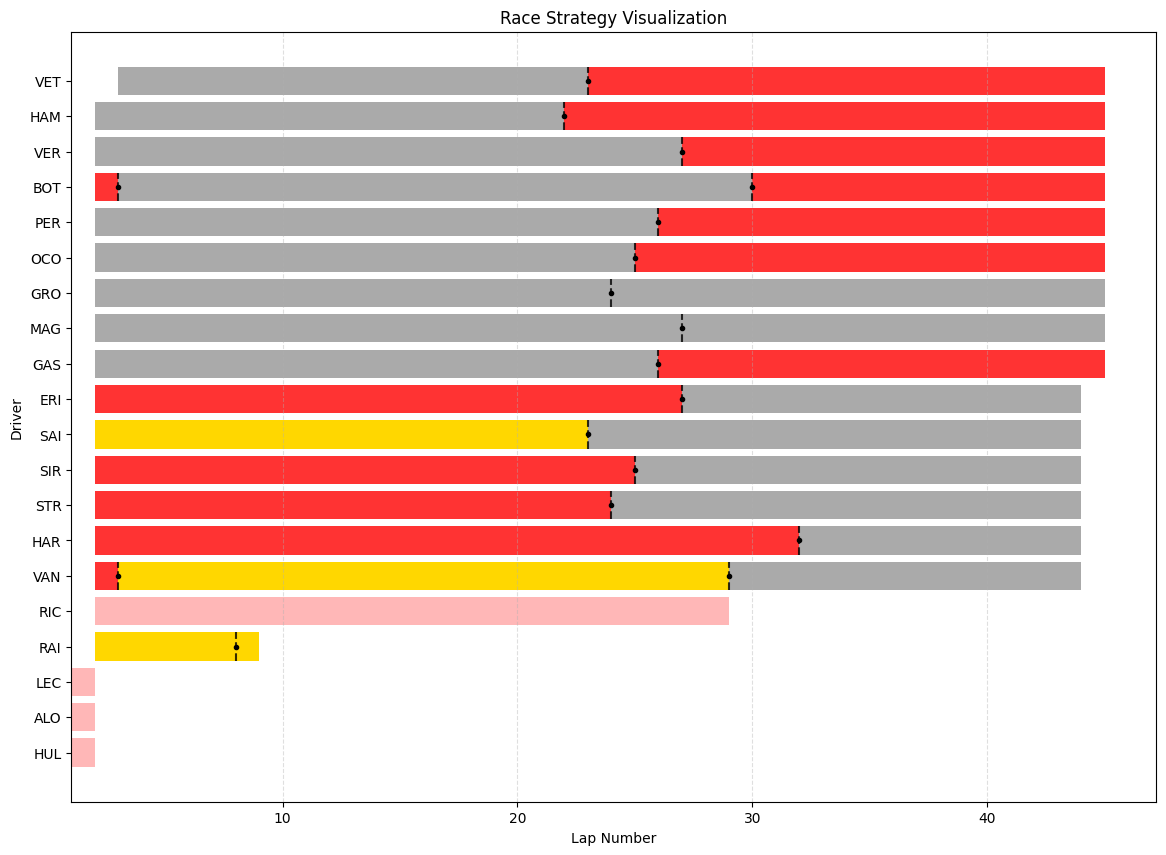

In [6]:
# Get finishing order
finishing_order = session.results.sort_values('Position')['Abbreviation'].tolist()
drivers = finishing_order[::-1]  # P1 at bottom

results = session.results
dnf_drivers = session.results[
    (session.results['Position'].isna()) |
    (session.results['Status'].str.contains('Accident|Engine|Retired|Gearbox', na=False))
]['Abbreviation'].tolist()


y_positions = {driver: i for i, driver in enumerate(drivers)}

fig, ax = plt.subplots(figsize=(14,10))

for driver in drivers:
    driver_laps = laps[laps['Driver'] == driver]
    stints = driver_laps.groupby('Stint')

    alpha = 0.35 if driver in dnf_drivers else 1.0
    y = y_positions[driver]

    for stint, data in stints:
        compound = data['Compound'].mode()[0]
        width = data['LapNumber'].max() - data['LapNumber'].min() + 1

        ax.barh(
            y,
            width,
            left=data['LapNumber'].min(),
            color=COMPOUND_COLORS.get(compound, '#AAAAAA'),
            alpha=alpha
        )

    # Pit stop markers
    pit_laps = driver_laps.loc[
        driver_laps['Stint'].diff() == 1, 'LapNumber'
    ]

    for lap in pit_laps:
        ax.plot(lap, y, marker='o', color='black', markersize=3, zorder=6)
        ax.vlines(
            lap,
            y - 0.4,
            y + 0.4,
            colors='black',
            linestyles='dashed',
            linewidth=1.5,
            alpha=0.8,
            zorder=5
        )

# Fix y-axis labels
ax.set_yticks(range(len(drivers)))
ax.set_yticklabels(drivers)

ax.set_xlabel("Lap Number")
ax.set_ylabel("Driver")
ax.set_title("Race Strategy Visualization")
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.show()
